In [3]:
import numpy as np
import pandas as pd

In [4]:
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
cats = pd.read_csv('item_categories.csv')
train = pd.read_csv('sales_train.csv')
test  = pd.read_csv('test.csv')

In [6]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [7]:
cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [8]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [9]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [10]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

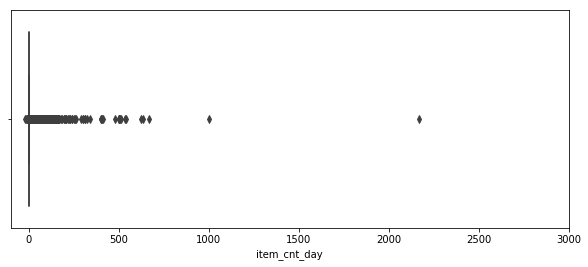

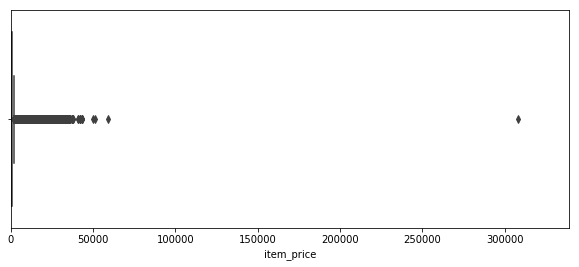

In [12]:
#removing outliers

plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [5]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

In [9]:
train = train[train['item_cnt_day'] < 2000]

In [10]:
train = train[train['item_price'] < 300000]

In [11]:
#there is one item with price below zero, filling it with median

median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

In [12]:
#several shops are duplicates of each other (according to its name), fixing train and test set

# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [13]:
#each shop_name starts with the city name

cities = shops['shop_name'].str.split(' ').map(lambda row: row[0])
cities.unique()

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

In [14]:
shops['city'] = shops['shop_name'].str.split(' ').map(lambda row: row[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'

In [15]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit_transform(shops['city'])

array([29, 29,  0,  1,  2,  3,  4,  4,  4,  5,  6,  6,  7,  8,  8,  9, 10,
       11, 11, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14,
       15, 15, 16, 16, 17, 18, 18, 18, 19, 19, 20, 20, 21, 22, 23, 24, 24,
       24, 25, 25, 26, 27, 28, 29, 29, 30])

In [16]:
shops['city_label'] = le.fit_transform(shops['city'])
shops.drop(['shop_name', 'city'], axis = 1, inplace = True)
shops.head()

,shop_id,city_label
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


In [17]:
#each category contains type and subtype in its name


main_categories = cats['item_category_name'].str.split('-')
cats['main_category_id'] = main_categories.map(lambda row: row[0].strip())
cats['main_category_id'] = le.fit_transform(cats['main_category_id'])

# Some items don't have sub-categories. For those, we will use the main category as a sub-category
cats['sub_category_id'] = main_categories.map(lambda row: row[1].strip() if len(row) > 1 else row[0].strip())
cats['sub_category_id'] = le.fit_transform(cats['sub_category_id'])

In [23]:
cats.head()

,item_category_name,item_category_id,main_category_id,sub_category_id
0,PC - Гарнитуры/Наушники,0,0,29
1,Аксессуары - PS2,1,1,9
2,Аксессуары - PS3,2,1,10
3,Аксессуары - PS4,3,1,11
4,Аксессуары - PSP,4,1,13


In [18]:
train['date'] = pd.to_datetime(train['date'], format='%d.%m.%Y')
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [19]:
#Generating product of Shop-Item pairs for each month in the training data

from tqdm import tqdm_notebook

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float16)
    df[int_cols]   = df[int_cols].astype(np.int16)
    
    return df

In [20]:
months = train['date_block_num'].unique()

In [22]:
from itertools import product

cartesian = []
for month in months:
    shops_in_month = train.loc[train['date_block_num']==month, 'shop_id'].unique()
    items_in_month = train.loc[train['date_block_num']==month, 'item_id'].unique()
    cartesian.append(np.array(list(product(*[shops_in_month, items_in_month, [month]])), dtype='int32'))

In [23]:
cartesian_df = pd.DataFrame(np.vstack(cartesian), columns = ['shop_id', 'item_id', 'date_block_num'], dtype=np.int32)

In [24]:
cartesian_df.shape

(10913804, 3)

In [25]:
#Aggregating sales to a monthly level and clipping target variable

x = train.groupby(['shop_id', 'item_id', 'date_block_num'])['item_cnt_day'].sum().rename('item_cnt_month').reset_index()
x.head()

,shop_id,item_id,date_block_num,item_cnt_month
0,2,27,0,1.0
1,2,27,17,1.0
2,2,30,2,1.0
3,2,30,5,1.0
4,2,30,15,1.0


In [26]:
x.shape

(1609123, 4)

In [27]:
#merging both dataframes

new_train = pd.merge(cartesian_df, x, on=['shop_id', 'item_id', 'date_block_num'], how='left').fillna(0)

In [28]:
new_train['item_cnt_month'] = np.clip(new_train['item_cnt_month'], 0, 20)

In [29]:
new_train.sort_values(['date_block_num','shop_id','item_id'], inplace = True)
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_month
114910,2,19,0,0.0
117150,2,27,0,1.0
120623,2,28,0,0.0
118316,2,29,0,0.0
114602,2,32,0,0.0


In [30]:
#Appending Test Set to Training Set

test.insert(loc=3, column='date_block_num', value=34)

In [31]:
test['item_cnt_month'] = 0

In [32]:
test.head()

,ID,shop_id,item_id,date_block_num,item_cnt_month
0,0,5,5037,34,0
1,1,5,5320,34,0
2,2,5,5233,34,0
3,3,5,5232,34,0
4,4,5,5268,34,0


In [33]:
new_train = new_train.append(test.drop('ID', axis = 1))

In [34]:
#Merging Shops, Items, Categories dataframes to add the city label, category_id, main category and sub-category feature

new_train = pd.merge(new_train, shops, on=['shop_id'], how='left')
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_label
0,2,19,0,0.0,0
1,2,27,0,1.0,0
2,2,28,0,0.0,0
3,2,29,0,0.0,0
4,2,32,0,0.0,0


In [35]:
new_train = pd.merge(new_train, items.drop('item_name', axis = 1), on=['item_id'], how='left')
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_label,item_category_id
0,2,19,0,0.0,0,40
1,2,27,0,1.0,0,19
2,2,28,0,0.0,0,30
3,2,29,0,0.0,0,23
4,2,32,0,0.0,0,40


In [37]:
new_train = pd.merge(new_train, cats.drop('item_category_name', axis = 1), on=['item_category_id'], how='left')
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_label,item_category_id,main_category_id,sub_category_id
0,2,19,0,0.0,0,40,11,4
1,2,27,0,1.0,0,19,5,10
2,2,28,0,0.0,0,30,8,55
3,2,29,0,0.0,0,23,5,16
4,2,32,0,0.0,0,40,11,4


In [40]:
#Adding month feature

new_train['month'] = new_train['date_block_num'] % 12

In [41]:
#Training

x_train = new_train[new_train.date_block_num < 33].drop(['item_cnt_month'], axis=1)
y_train = new_train[new_train.date_block_num < 33]['item_cnt_month']

x_valid = new_train[new_train.date_block_num == 33].drop(['item_cnt_month'], axis=1)
y_valid = new_train[new_train.date_block_num == 33]['item_cnt_month']

x_test = new_train[new_train.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [49]:
#LSTM model

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import backend as K


def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred -y_true), axis=-1))

model_lstm = Sequential()
model_lstm.add(LSTM(15, input_shape=(1,8)))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam',  metrics=[rmse])

In [50]:
# Reshape the data between -1 and 1 and to 3D

from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(-1, 1))
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.fit_transform(x_valid)
x_test_scaled = scaler.fit_transform(x_test)

C:\Users\HP PC\anaconda3\envs\tsa_course\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\HP PC\anaconda3\envs\tsa_course\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\HP PC\anaconda3\envs\tsa_course\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [51]:
x_train_reshaped = x_train_scaled.reshape((x_train_scaled.shape[0], 1, x_train_scaled.shape[1]))
x_val_reshaped = x_valid_scaled.reshape((x_valid_scaled.shape[0], 1, x_valid_scaled.shape[1]))
x_test_reshaped = x_test_scaled.reshape((x_test_scaled.shape[0], 1, x_test_scaled.shape[1]))

In [52]:
history = model_lstm.fit(x_train_reshaped, y_train, validation_data=(x_val_reshaped, y_valid),epochs=10, batch_size=512, verbose=2, shuffle=False)
y_pre = model_lstm.predict(x_val_reshaped)


Train on 10675632 samples, validate on 238172 samples
Epoch 1/10
 - 140s - loss: 1.4593 - rmse: 0.4875 - val_loss: 1.2837 - val_rmse: 0.4351
Epoch 2/10
 - 55s - loss: 1.4375 - rmse: 0.4815 - val_loss: 1.2796 - val_rmse: 0.4390
Epoch 3/10
 - 52s - loss: 1.4268 - rmse: 0.4756 - val_loss: 1.2907 - val_rmse: 0.4338
Epoch 4/10
 - 53s - loss: 1.4232 - rmse: 0.4747 - val_loss: 1.2888 - val_rmse: 0.4132
Epoch 5/10
 - 57s - loss: 1.4213 - rmse: 0.4741 - val_loss: 1.2897 - val_rmse: 0.4116
Epoch 6/10
 - 53s - loss: 1.4197 - rmse: 0.4735 - val_loss: 1.2911 - val_rmse: 0.4185
Epoch 7/10
 - 53s - loss: 1.4182 - rmse: 0.4731 - val_loss: 1.2894 - val_rmse: 0.4317
Epoch 8/10
 - 52s - loss: 1.4170 - rmse: 0.4728 - val_loss: 1.2896 - val_rmse: 0.4467
Epoch 9/10
 - 53s - loss: 1.4160 - rmse: 0.4725 - val_loss: 1.2899 - val_rmse: 0.4542
Epoch 10/10
 - 53s - loss: 1.4151 - rmse: 0.4723 - val_loss: 1.2890 - val_rmse: 0.4538


In [ ]:
#submission

Y_test = model_lstm.predict(x_test_reshaped)
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test.flatten()
})
submission.to_csv('lstm_submissionfinal.csv', index=False)